# Japanese hiragana characters classification
http://codh.rois.ac.jp/kmnist/index.html.en

Tarin Clanuwat, Mikel Bober-Irizar, Asanobu Kitamoto, Alex Lamb, Kazuaki Yamamoto, David Ha, "Deep Learning for Classical Japanese Literature", arXiv:1812.01718. 

"KMNIST Dataset" (created by CODH), adapted from "Kuzushiji Dataset" (created by NIJL and others), doi:10.20676/00000341 

https://www.kaggle.com/gpreda/classifying-cursive-hiragana-kmnist-using-cnn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from IPython.display import SVG

In [3]:
import os
path = "data"
os.chdir(path)

In [4]:
# Preprocessing
NUM_CLASSES = 10
IMG_ROWS = 28
IMG_COLS = 28

# Validation set
VAL_SIZE = 0.1
RANDOM_STATE = 42
# Model
NO_EPOCHS = 20
# Batch
# - Full batch: batch size = use entire dataset
# - Mini batch: batch size = smaller portion of the data (Power of 2 to take full advantage of GPU, 32 is a good start)
# - Stochastice: batch size = 1
BATCH_SIZE = 32 
# Learning rate from 1 to 1e-6
LR = 0.01

In [5]:
train_images = np.load('kmnist-train-imgs.npz')['arr_0']
test_images = np.load('kmnist-test-imgs.npz')['arr_0']
train_labels = np.load('kmnist-train-labels.npz')['arr_0']
test_labels = np.load('kmnist-test-labels.npz')['arr_0']

In [6]:
char_df = pd.read_csv('kmnist_classmap.csv', encoding = 'utf-8')
char_df

,index,codepoint,char
0,0,U+304A,お
1,1,U+304D,き
2,2,U+3059,す
3,3,U+3064,つ
4,4,U+306A,な
5,5,U+306F,は
6,6,U+307E,ま
7,7,U+3084,や
8,8,U+308C,れ
9,9,U+3092,を


In [7]:
print("KMNIST train images shape:", train_images.shape)
print("KMNIST test images shape:", test_images.shape)
print("KMNIST train labels shape:", train_labels.shape)
print("KMNIST test labels shape:", test_labels.shape)

KMNIST train images shape: (60000, 28, 28)
KMNIST test images shape: (10000, 28, 28)
KMNIST train labels shape: (60000,)
KMNIST test labels shape: (10000,)


In [8]:
train_labels

array([8, 7, 0, ..., 0, 4, 9], dtype=uint8)

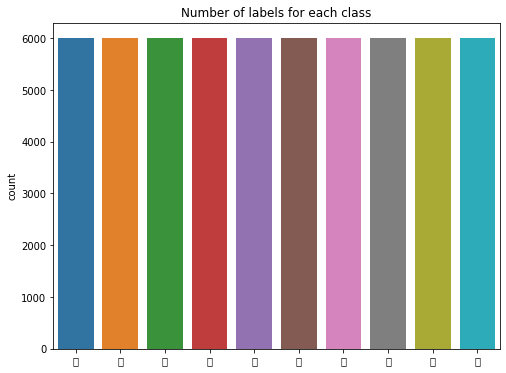

In [9]:
labels = char_df['char']
f, ax = plt.subplots(1,1, figsize=(8,6))
g = sns.countplot(train_labels)
g.set_title("Number of labels for each class")
g.set_xticklabels(labels)
plt.show()    

In [10]:
def plot_sample_images_data(images, labels):
    plt.figure(figsize=(12,12))
    for i in tqdm_notebook(range(10)):
        imgs = images[np.where(labels == i)]
        lbls = labels[np.where(labels == i)]
        for j in range(10):
            plt.subplot(10,10,i*10+j+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(imgs[j], cmap=plt.cm.binary)
            plt.xlabel(lbls[j])

  0%|          | 0/10 [00:00<?, ?it/s]

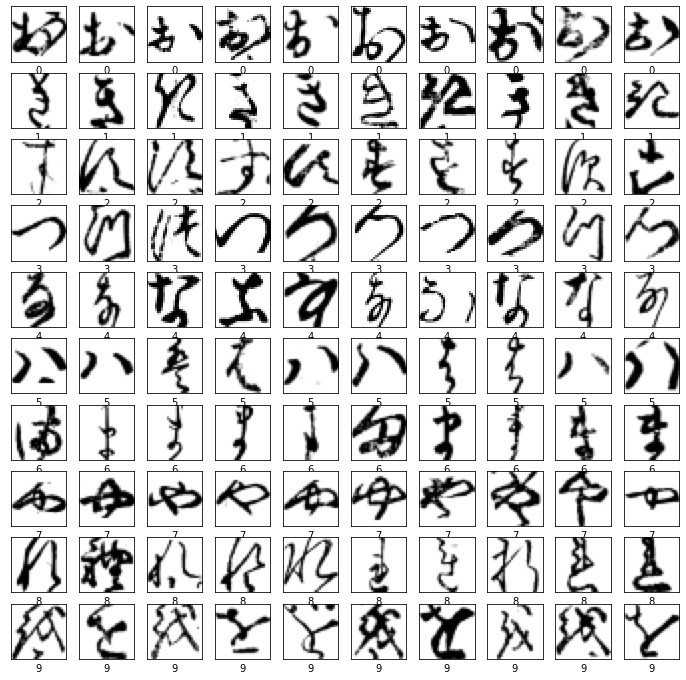

In [11]:
plot_sample_images_data(train_images, train_labels)

  0%|          | 0/10 [00:00<?, ?it/s]

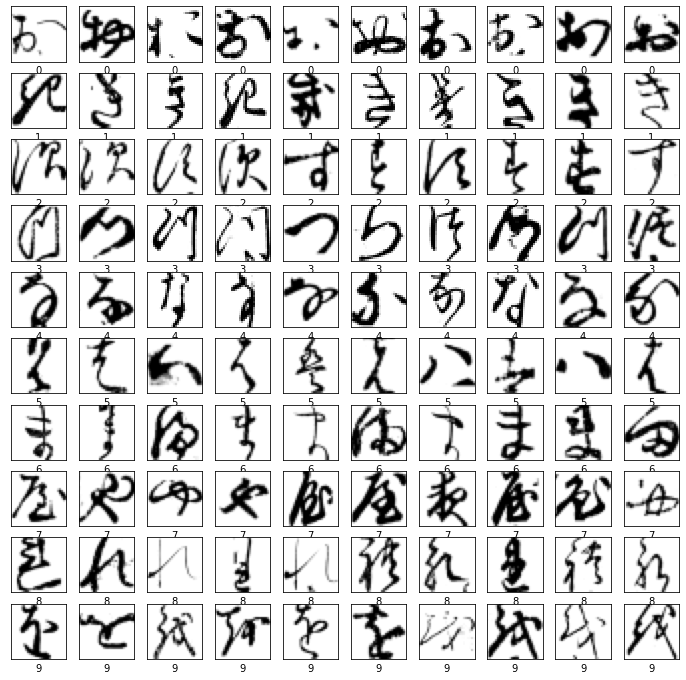

In [12]:
plot_sample_images_data(test_images, test_labels)

# Pre-processing

In [13]:
def data_preprocessing(images, labels):
    out_y = tf.keras.utils.to_categorical(labels, NUM_CLASSES)
    num_images = images.shape[0]
    x_shaped_array = images.reshape(num_images, IMG_ROWS, IMG_COLS, 1)
    out_x = x_shaped_array / 255
    return out_x, out_y

In [14]:
X, y = data_preprocessing(train_images, train_labels)
X_test, y_test = data_preprocessing(test_images, test_labels)

In [15]:
print("KMNIST train images shape:", train_images.shape)
print("KMNIST test images shape:", test_images.shape)
print("KMNIST train labels shape:", train_labels.shape)
print("KMNIST test labels shape:", test_labels.shape)
print("X shape:", X.shape)
print("X_test shape:", X_test.shape)
print("y shape:", y.shape)
print("y_test shape:", y_test.shape)

KMNIST train images shape: (60000, 28, 28)
KMNIST test images shape: (10000, 28, 28)
KMNIST train labels shape: (60000,)
KMNIST test labels shape: (10000,)
X shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)
y shape: (60000, 10)
y_test shape: (10000, 10)


In [16]:
y_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [17]:
# Validation 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SIZE, random_state=RANDOM_STATE, shuffle=True, stratify=y)

In [18]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (54000, 28, 28, 1)
X_val shape: (6000, 28, 28, 1)
y_train shape: (54000, 10)
y_test shape: (10000, 10)


In [19]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [20]:
def plot_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(ydf[0], order = np.arange(0,10))
    g.set_title("Number of items for each class")
    g.set_xlabel("Category")
            
    plt.show()  

def get_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    # Get the count for each label
    label_counts = ydf[0].value_counts()

    # Get total number of samples
    total_samples = len(yd)

    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        label_char = char_df[char_df['index']==label]['char'].item()
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{}({}):   {} or {}%".format(label, label_char, count, percent))

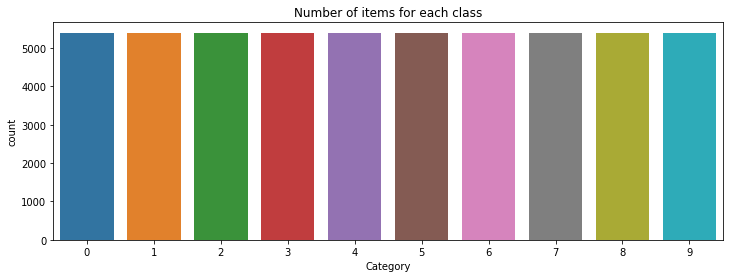

1(き):   5400 or 10.0%
0(お):   5400 or 10.0%
9(を):   5400 or 10.0%
8(れ):   5400 or 10.0%
5(は):   5400 or 10.0%
3(つ):   5400 or 10.0%
4(な):   5400 or 10.0%
2(す):   5400 or 10.0%
6(ま):   5400 or 10.0%
7(や):   5400 or 10.0%


In [21]:
plot_count_per_class(np.argmax(y_train,axis=1))
get_count_per_class(np.argmax(y_train,axis=1))

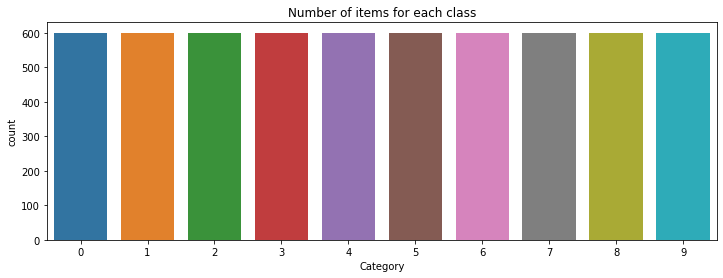

6(ま):   600 or 10.0%
8(れ):   600 or 10.0%
0(お):   600 or 10.0%
1(き):   600 or 10.0%
7(や):   600 or 10.0%
5(は):   600 or 10.0%
9(を):   600 or 10.0%
3(つ):   600 or 10.0%
4(な):   600 or 10.0%
2(す):   600 or 10.0%


In [22]:
plot_count_per_class(np.argmax(y_val,axis=1))
get_count_per_class(np.argmax(y_val,axis=1))

# 1st MODEL: fully connected neural network

## Model creation

### Activation function
Sigmoid
Hyperbolic tangent
ReLU: relu
Leaky Relu

In [69]:
model1 = keras.models.Sequential()
model1.add(keras.layers.Flatten(input_shape=[IMG_ROWS, IMG_COLS]))
model1.add(keras.layers.Dense(100, activation="relu")) 
model1.add(keras.layers.Dense(100, activation="relu"))
model1.add(keras.layers.Dense(10, activation="softmax"))

In [70]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [71]:
model1.layers

In [72]:
hidden1 = model1.layers[1]
hidden1.name

'dense_4'

In [73]:
weights, biases = hidden1.get_weights()

In [74]:
# Weights are randomly initialized
# kernel_initializer can be used as an initialization method
weights

array([[-0.0052941 , -0.04889423, -0.01538271, ...,  0.01207078,
         0.07797046,  0.07767019],
       [-0.02279913,  0.01177132,  0.04895046, ..., -0.05316165,
        -0.04181882, -0.02217356],
       [ 0.03574529,  0.06034395, -0.03752536, ..., -0.04171925,
        -0.07193711,  0.02551837],
       ...,
       [-0.07654697,  0.07221572,  0.04998536, ...,  0.01714764,
         0.06912789, -0.02949324],
       [ 0.06654407,  0.04518981,  0.04073375, ..., -0.02725448,
        -0.0713079 ,  0.0521819 ],
       [ 0.07542074, -0.0098544 , -0.04838832, ...,  0.06021515,
         0.0429057 , -0.00308961]], dtype=float32)

In [75]:
# Biases are initialized to 0
# bias_initializer can be used as an initialization method
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [76]:
print("Weights shape:", weights.shape)
print("Biases shape:", biases.shape)

Weights shape: (784, 100)
Biases shape: (100,)


## Compile model 

In [77]:
# Optimizer, loss, metric
opt1 = tf.keras.optimizers.SGD(lr=LR)
opt2 = tf.keras.optimizers.Adagrad(lr=LR) # with default other parameters
opt3 = tf.keras.optimizers.RMSprop(lr=LR) # with default other parameters
opt4 = tf.keras.optimizers.Adam(lr=LR)    # with default other parameters

model1.compile(optimizer=opt2,
               loss="categorical_crossentropy",
               metrics=["accuracy"])

## Fit Model

In [78]:
hist1 = model1.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NO_EPOCHS, verbose=True, validation_data=(X_val, y_val))

Epoch 1/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6715 - accuracy: 0.8018 - val_loss: 0.4330 - val_accuracy: 0.8725
Epoch 2/20
1688/1688 [==============================] - 2s 979us/step - loss: 0.3701 - accuracy: 0.8893 - val_loss: 0.3456 - val_accuracy: 0.9012
Epoch 3/20
1688/1688 [==============================] - 2s 949us/step - loss: 0.2990 - accuracy: 0.9114 - val_loss: 0.3054 - val_accuracy: 0.9122
Epoch 4/20
1688/1688 [==============================] - 2s 974us/step - loss: 0.2571 - accuracy: 0.9246 - val_loss: 0.2735 - val_accuracy: 0.9202
Epoch 5/20
1688/1688 [==============================] - 2s 991us/step - loss: 0.2267 - accuracy: 0.9343 - val_loss: 0.2590 - val_accuracy: 0.9237
Epoch 6/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2037 - accuracy: 0.9407 - val_loss: 0.2400 - val_accuracy: 0.9308
Epoch 7/20
1688/1688 [==============================] - 2s 990us/step - loss: 0.1852 - accuracy: 0.9473 - val_loss: 0.2317 - val

In [79]:
model1.optimizer.get_config()

{'name': 'Adagrad',
 'learning_rate': 0.01,
 'decay': 0.0,
 'initial_accumulator_value': 0.1,
 'epsilon': 1e-07}

In [80]:
hist1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Plot loss & accuracy for training & validation set

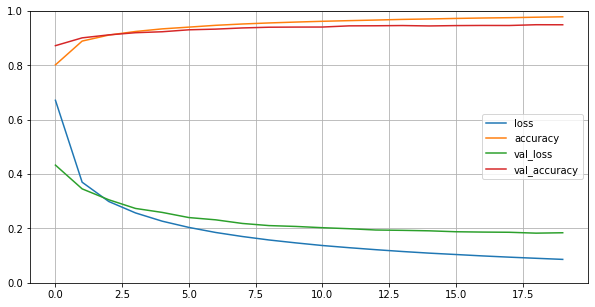

In [81]:
pd.DataFrame(hist1.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # Régler la plage verticale sur [0-1]
plt.show()

## Model evaluation

In [82]:
model1.evaluate(X_test, y_test)

313/313 [==============================] - 0s 701us/step - loss: 0.4346 - accuracy: 0.8800


[0.434583455324173, 0.8799999952316284]

## Predictions

### Predict probability

In [34]:
# Prediction on the 5 first images in the test dataset
X_new = X_test[:5]

In [35]:
y_proba = model1.predict(X_new)

In [36]:
y_proba.round(2)

array([[0.  , 0.3 , 0.02, 0.08, 0.05, 0.25, 0.  , 0.  , 0.29, 0.01],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.99, 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

### Predict classes

In [37]:
y_pred = model1.predict_classes(X_new)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [38]:
y_pred

array([1, 9, 3, 8, 3], dtype=int64)

In [39]:
#np.array(class_names)[y_pred]

# 2nd MODEL: CNN

## Model creation

In [25]:
model2 = Sequential()

model2.add(Conv2D(64, (3, 3), strides = (1,1), padding='same', activation="relu", input_shape=X_train.shape[1:],))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (3, 3), strides = (1,1), padding='same', activation="relu"))
model2.add(Conv2D(128, (3, 3), strides = (1,1), padding='same', activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(256, (3, 3), strides = (1,1), padding='same', activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())

model2.add(keras.layers.Dense(128, activation="relu"))
model2.add(Dropout(0.5))

model2.add(keras.layers.Dense(64, activation="relu"))
model2.add(Dropout(0.5))

model2.add(keras.layers.Dense(NUM_CLASSES, activation="softmax"))

In [26]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 256)        

In [27]:
model2.layers

## Compile model 

In [28]:
# Optimizer, loss, metric
LR=0.001
opt1 = tf.keras.optimizers.SGD(lr=LR)
opt2 = tf.keras.optimizers.Adagrad(lr=LR) # with default other parameters
opt3 = tf.keras.optimizers.RMSprop(lr=LR) # with default other parameters
opt4 = tf.keras.optimizers.Adam(lr=LR)    # with default other parameters

model2.compile(optimizer=opt4,
               loss="categorical_crossentropy",
               metrics=["accuracy"])

## Fit Model

In [29]:
hist2 = model2.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=5, verbose=True, validation_data=(X_val, y_val))

Epoch 1/5
1688/1688 [==============================] - 265s 157ms/step - loss: 0.5681 - accuracy: 0.8174 - val_loss: 0.0984 - val_accuracy: 0.9690
Epoch 2/5
1688/1688 [==============================] - 279s 165ms/step - loss: 0.1746 - accuracy: 0.9526 - val_loss: 0.0677 - val_accuracy: 0.9822
Epoch 3/5
1688/1688 [==============================] - 283s 167ms/step - loss: 0.1228 - accuracy: 0.9667 - val_loss: 0.0578 - val_accuracy: 0.9825
Epoch 4/5
1688/1688 [==============================] - 281s 167ms/step - loss: 0.0934 - accuracy: 0.9745 - val_loss: 0.0486 - val_accuracy: 0.9888
Epoch 5/5
1688/1688 [==============================] - 281s 167ms/step - loss: 0.0815 - accuracy: 0.9782 - val_loss: 0.0527 - val_accuracy: 0.9870


In [30]:
model2.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

## Plot loss & accuracy for training & validation set

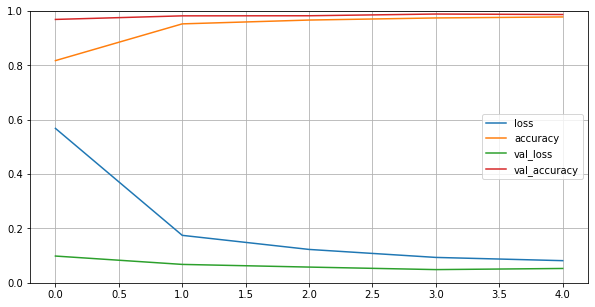

In [31]:
pd.DataFrame(hist2.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # Régler la plage verticale sur [0-1]
plt.show()

## Model evaluation

In [32]:
model2.evaluate(X_test, y_test)

313/313 [==============================] - 13s 43ms/step - loss: 0.1807 - accuracy: 0.9598


[0.1807345151901245, 0.9598000049591064]

# 3rd MODEL: ResNet

## Function Residual Unit

In [29]:
class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                            padding="same", use_bias=False),
                            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1,
                            padding="same", use_bias=False),
                            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

## Model creation

In [36]:
model3 = keras.models.Sequential()
model3.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=X_train.shape[1:],
                              padding="same", use_bias=False))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Activation("relu"))
model3.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model3.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model3.add(keras.layers.GlobalAvgPool2D())
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(10, activation="softmax"))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_108 (Conv2D)          (None, 14, 14, 64)        3136      
_________________________________________________________________
batch_normalization_108 (Bat (None, 14, 14, 64)        256       
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
residual_unit_48 (ResidualUn (None, 7, 7, 64)          74240     
_________________________________________________________________
residual_unit_49 (ResidualUn (None, 7, 7, 64)          74240     
_________________________________________________________________
residual_unit_50 (ResidualUn (None, 7, 7, 64)         

In [37]:
model3.layers

## Compile model 

In [38]:
# Optimizer, loss, metric
LR=0.01
opt1 = tf.keras.optimizers.SGD(lr=LR)
opt2 = tf.keras.optimizers.Adagrad(lr=LR) # with default other parameters
opt3 = tf.keras.optimizers.RMSprop(lr=LR) # with default other parameters
opt4 = tf.keras.optimizers.Adam(lr=LR)    # with default other parameters

model3.compile(optimizer=opt4,
               loss="categorical_crossentropy",
               metrics=["accuracy"])

## Fit Model

In [39]:
hist3 = model3.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=5, verbose=True, validation_data=(X_val, y_val))

Epoch 1/5
1688/1688 [==============================] - 2739s 2s/step - loss: 0.7942 - accuracy: 0.7835 - val_loss: 0.3652 - val_accuracy: 0.8863
Epoch 2/5
1688/1688 [==============================] - 4238s 3s/step - loss: 0.1630 - accuracy: 0.9526 - val_loss: 0.1275 - val_accuracy: 0.9657
Epoch 3/5
1688/1688 [==============================] - 2761s 2s/step - loss: 0.1170 - accuracy: 0.9666 - val_loss: 0.1625 - val_accuracy: 0.9507
Epoch 4/5
1688/1688 [==============================] - 2761s 2s/step - loss: 0.0938 - accuracy: 0.9736 - val_loss: 0.1436 - val_accuracy: 0.9600
Epoch 5/5
1688/1688 [==============================] - 2621s 2s/step - loss: 0.0818 - accuracy: 0.9769 - val_loss: 0.1079 - val_accuracy: 0.9657


In [41]:
model3.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.01,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

## Plot loss & accuracy for training & validation set

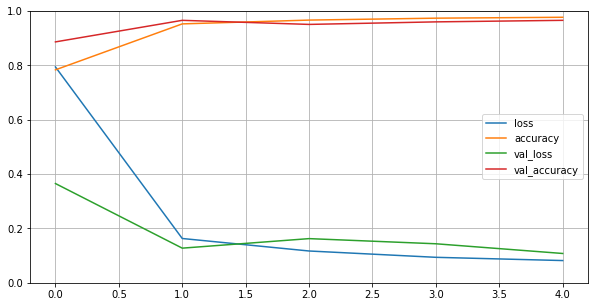

In [43]:
pd.DataFrame(hist3.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # Régler la plage verticale sur [0-1]
plt.show()

## Model evaluation

In [44]:
model3.evaluate(X_test, y_test)

313/313 [==============================] - 15s 48ms/step - loss: 0.2486 - accuracy: 0.9283


[0.24858123064041138, 0.9283000230789185]

# 4th MODEL: Variational AutoEnconder

In [20]:
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

## Pre-processing

In [113]:
x_train = X_train.astype('float32')
x_test = X_test.astype('float32')

In [114]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train_flat.shape)
print(x_test_flat.shape)

(54000, 784)
(10000, 784)


In [115]:
y_test = y_test.astype('float32')
y_test_flat = y_test.reshape((len(y_test), np.prod(y_test.shape[1:])))

## Sampling function

In [116]:
def sampling(args):
    """
    Transforms parameters defining the latent space into a normal distribution.
    """
    # Need to unpack arguments like this because of the way the Keras "Lambda" function works.
    mu, log_sigma = args
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=tf.shape(mu))
    sigma = K.exp(log_sigma)
    return mu + K.exp(0.5 * sigma) * epsilon

## Encoder model

In [117]:
hidden_dim = 256
batch_size = 128
latent_dim = 2 
# this is the dimension of each of the vectors representing the two parameters
# that will get transformed into a normal distribution
epochs = 1


# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=(784, ), name='encoder_input')
x = Dense(hidden_dim, activation='relu')(inputs)


z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# NOTE: output of encoder model is *2* n-dimensional vectors:

z = Lambda(sampling, name='z')([z_mean, z_log_var])
# z is now one n dimensional vector representing the inputs 
encoder_model = Model(inputs, [z_mean, z_log_var, z], name='encoder')

## Decoder model

In [118]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,),)
x = Dense(hidden_dim, activation='relu')(latent_inputs)
outputs = Dense(784, activation='sigmoid')(x)
decoder_model = Model(latent_inputs, outputs, name='decoder')

## VAE model = Encoder + Decoder

In [118]:
# instantiate VAE model
outputs = decoder_model(encoder_model(inputs)[2])
vae_model = Model(inputs, outputs, name='vae_mlp')

In [119]:
# Examine each layer
for i, layer in enumerate(vae_model.layers):
    print("Layer", i+1)
    print("Name", layer.name)
    print("Input shape", layer.input_shape)
    print("Output shape", layer.output_shape)
    if not layer.weights:
        print("No weights for this layer")
        continue
    for i, weight in enumerate(layer.weights):
        print("Weights", i+1)
        print("Name", weight.name)
        print("Weights shape:", weight.shape.as_list())

Layer 1
Name encoder_input
Input shape [(None, 784)]
Output shape [(None, 784)]
No weights for this layer
Layer 2
Name encoder
Input shape (None, 784)
Output shape [(None, 2), (None, 2), (None, 2)]
Weights 1
Name dense_9/kernel:0
Weights shape: [784, 256]
Weights 2
Name dense_9/bias:0
Weights shape: [256]
Weights 3
Name z_mean/kernel:0
Weights shape: [256, 2]
Weights 4
Name z_mean/bias:0
Weights shape: [2]
Weights 5
Name z_log_var/kernel:0
Weights shape: [256, 2]
Weights 6
Name z_log_var/bias:0
Weights shape: [2]
Layer 3
Name decoder
Input shape (None, 2)
Output shape (None, 784)
Weights 1
Name dense_10/kernel:0
Weights shape: [2, 256]
Weights 2
Name dense_10/bias:0
Weights shape: [256]
Weights 3
Name dense_11/kernel:0
Weights shape: [256, 784]
Weights 4
Name dense_11/bias:0
Weights shape: [784]


## Reconstruction loss calculation

In [120]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= 784

In [121]:
kl_loss = 0.5 * (K.exp(z_log_var) - (1 + z_log_var) + K.square(z_mean))
kl_loss = K.sum(kl_loss, axis=-1)
total_vae_loss = K.mean(reconstruction_loss + kl_loss)

## All loss & compile model

In [122]:
vae_model.add_loss(total_vae_loss)

vae_model.compile(optimizer='rmsprop',
                  metrics=[tf.keras.metrics.Accuracy(name="accuracy", dtype=None)])
    
vae_model.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 201988      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Functional)            (None, 784)          202256      encoder[0][2]                    
__________________________________________________________________________________________________
tf_op_layer_Minimum_3 (TensorFl [(None, 784)]        0           decoder[0][0]                    
____________________________________________________________________________________________

## Fit model

In [123]:
vae_model.fit(x_train_flat,
        epochs=epochs,
        batch_size=batch_size)

422/422 [==============================] - 3s 6ms/step - loss: 326.9139 - accuracy: 0.0000e+00


## Plot results

In [124]:
def mse_reconstruction(true, reconstructed):
    return np.sum(np.power(true - reconstructed, 2) / true.shape[1])

In [125]:
decoded_images = vae_model.predict(x_test_flat)
mse_reconstruction(decoded_images, x_test_flat)

912.4943

In [126]:
models = encoder_model, decoder_model 
data = x_test_flat, y_test

In [127]:
y_test.shape

(10000, 10)

In [131]:
y_color = np.argmax(y_test, axis = 1)
y_color

array([2, 9, 3, ..., 9, 4, 2], dtype=int64)

In [147]:
def plot_results_var(models,
                     data,
                     batch_size=128,
                     model_name="vae_mnist",
                     lim=4):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    
    # display a 2D plot of the digit classes in the latent space
    _, z_log_var, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    print(z_log_var)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_log_var[:, 0], z_log_var[:, 1], c=y_color)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-1.0 * lim, lim, n)
    grid_y = np.linspace(-1.0 * lim, lim, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

[[-2.3858829 -1.7817966]
 [-1.8592386 -2.5834637]
 [-1.8418251 -2.0565395]
 ...
 [-1.6514571 -2.4849474]
 [-1.0512933 -1.4816171]
 [-2.159636  -1.9270018]]


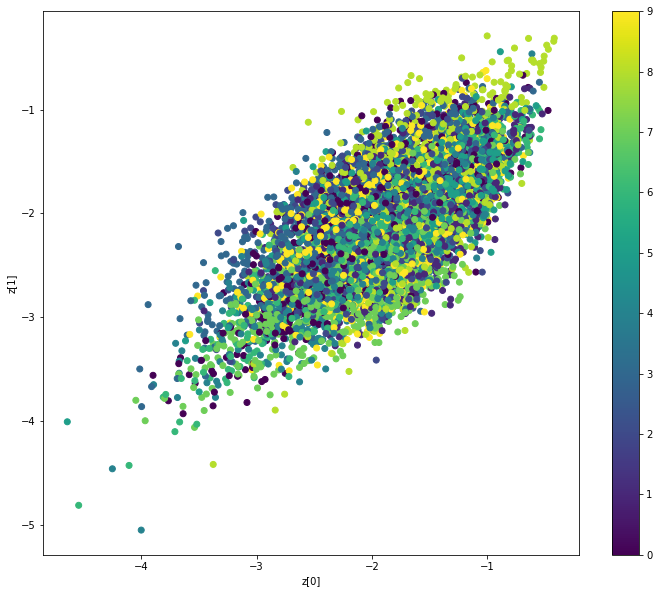

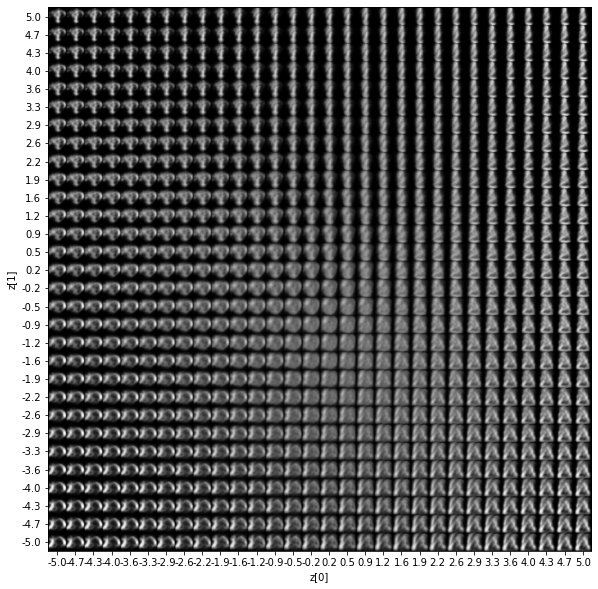

In [150]:
plot_results_var(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp", 
                 lim=5)